In [500]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(44)
np.random.seed(44)


class VanGenuchten:
    """Van Genuchten soil hydraulic model with trainable parameters"""

    def __init__(self, theta_s, theta_r, l=0.5):
        """
        Initialize with fixed parameters only.
        alpha, n, Ks will be trainable parameters in the PINN
        """
        self.theta_s = theta_s  # Fixed from bulk density/porosity
        self.theta_r = theta_r  # Fixed from PTF
        self.l = l  # Fixed Mualem parameter
        self._tiny = 1e-12

    def theta(self, h, alpha, n):
        """Compute water content given pressure head and parameters"""
        # Clamp parameters to reasonable ranges (SI units)
        alpha = torch.clamp(alpha, 1e-4, 100.0)  # 1/m (was 1e-6 to 1.0 for 1/cm)
        n = torch.clamp(n, 1.01, 10.0)
        
        m = 1.0 - 1.0 / n
        abs_h = torch.abs(h)
        
        # Numerical stability for large pressure heads
        alpha_h = alpha * abs_h
        alpha_h = torch.clamp(alpha_h, 0, 100)  # Prevent overflow
        
        denom = (1.0 + alpha_h.pow(n)).pow(m)
        denom = torch.clamp(denom, self._tiny, 1e6)  # Prevent division issues
        
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(
            h >= 0.0,
            torch.tensor(self.theta_s, device=h.device, dtype=h.dtype),
            theta_unsat,
        )

    def Se(self, h, alpha, n):
        """Compute effective saturation"""
        th = self.theta(h, alpha, n)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h, alpha, n, Ks):
        """Compute hydraulic conductivity given pressure head and parameters"""
        # Clamp parameters to reasonable ranges (SI units)
        alpha = torch.clamp(alpha, 1e-4, 100.0)  # 1/m (was 1e-6 to 1.0 for 1/cm)
        n = torch.clamp(n, 1.01, 10.0)
        Ks = torch.clamp(Ks, 1e-14, 1e-4)  # m/s (was 1e-12 to 1e-2 for cm/s)
        
        m = 1.0 - 1.0 / n
        Se = self.Se(h, alpha, n)
        
        # Numerical stability for Se^(1/m)
        Se_clamped = torch.clamp(Se, 1e-6, 1.0 - 1e-6)
        Se_1m = Se_clamped.pow(1.0 / m)
        
        # Compute K with numerical stability
        term1 = Se_clamped.pow(self.l)
        term2 = (1.0 - (1.0 - Se_1m).pow(m))
        term2 = torch.clamp(term2, 0.0, 1.0)  # Ensure positive
        K_unsat = Ks * term1 * term2.pow(2)
        
        return torch.where(
            h >= 0.0, Ks, torch.clamp(K_unsat, 1e-12 * Ks, Ks)
        )


class PressureHeadNet(nn.Module):
    """Neural network N_Θh(z,t) for approximating pressure head h(z,t)"""

    def __init__(self, hidden_dim=50, num_layers=4, t_max=86400.0):
        super().__init__()
        
        # Store time normalization parameter
        self.t_max = t_max

        layers = []
        # Input layer
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        # Output layer (linear, no activation)
        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        """Forward pass: (z,t) -> h"""
        # Normalize time input from [0, t_max] to [0, 1]
        t_normalized = t / self.t_max
        inputs = torch.cat([z, t_normalized], dim=1)
        h = self.net(inputs)
        return h


class InverseRichardsPINN(nn.Module):
    """
    Physics-Informed Neural Network for inverse modeling of Richards' equation
    Estimates soil parameters: alpha, n, Ks
    """

    def __init__(self, fixed_params, initial_params, L, z_r, c, network_config, t_max=86400.0):
        """
        Args:
            fixed_params: dict with 'theta_s', 'theta_r', 'l'
            initial_params: dict with initial guesses for 'alpha', 'n', 'Ks'
            L: depth of soil column (positive value)
            z_r: rooting depth (positive value)
            c: root decay parameter
            network_config: dict with 'hidden_dim' and 'num_layers'
            t_max: maximum time value for normalization (default: 86400.0 seconds = 24 hours)
        """
        super().__init__()

        # Neural network for pressure head
        self.h_net = PressureHeadNet(
            hidden_dim=network_config["hidden_dim"],
            num_layers=network_config["num_layers"],
            t_max=t_max,
        )

        # Soil hydraulic model with fixed parameters
        self.soil = VanGenuchten(
            theta_s=fixed_params["theta_s"],
            theta_r=fixed_params["theta_r"],
            l=fixed_params.get("l", 0.5),
        )

        # Trainable soil parameters (using log transform for positive constraints)
        self.log_alpha_param = nn.Parameter(
            torch.tensor(np.log(initial_params["alpha"]), dtype=torch.float32)
        )
        self.log_n_minus_1_param = nn.Parameter(
            torch.tensor(np.log(initial_params["n"] - 1.0), dtype=torch.float32)
        )
        self.log_Ks_param = nn.Parameter(
            torch.tensor(np.log(abs(initial_params["Ks"])), dtype=torch.float32)
        )

        # Domain parameters
        self.L = L  # Soil column depth
        self.z_r = z_r  # Rooting depth
        self.c = c  # Root decay parameter

    def get_alpha(self):
        """Get alpha parameter with positive constraint"""
        return torch.exp(self.log_alpha_param)
    
    def get_n(self):
        """Get n parameter with n > 1 constraint"""
        return 1.0 + torch.exp(self.log_n_minus_1_param)
    
    def get_Ks(self):
        """Get Ks parameter with positive constraint"""
        return torch.exp(self.log_Ks_param)

    def forward(self, z, t):
        """Forward pass: return h(z,t)"""
        return self.h_net(z, t)

    def root_distribution(self, z):
        """
        Normalized root density distribution β(z)
        Using exponential decay: β(z) = c * exp(c*z) for -z_r ≤ z ≤ 0
        """
        beta = torch.where(
            (z >= -self.z_r) & (z <= 0),
            self.c * torch.exp(self.c * z),
            torch.zeros_like(z),
        )
        # Normalize (approximation for discrete points)
        return beta

    def sink_term(self, z, t, T_p):
        """
        Root water uptake S(z,t) = β(z) * T_p(t)
        Args:
            T_p: potential transpiration rate function or tensor
        """
        beta = self.root_distribution(z)
        if callable(T_p):
            return beta * T_p(t)
        else:
            return beta * T_p

    def compute_derivatives(self, z, t):
        """Compute required derivatives for PDE residual"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)

        h = self.forward(z, t)

        # Get soil parameters
        alpha, n, Ks = self.get_alpha(), self.get_n(), self.get_Ks()

        # Compute θ(h)
        theta = self.soil.theta(h, alpha, n)

        # ∂θ/∂t
        dtheta_dt = torch.autograd.grad(theta.sum(), t, create_graph=True)[0]

        # ∂h/∂z
        dh_dz = torch.autograd.grad(h.sum(), z, create_graph=True)[0]

        # K(h)
        K = self.soil.K(h, alpha, n, Ks)

        # q = -K(∂h/∂z + 1)
        q = -K * (dh_dz + 1.0)

        # ∂q/∂z
        dq_dz = torch.autograd.grad(q.sum(), z, create_graph=True)[0]

        return dtheta_dt, dq_dz, q, K, dh_dz

    def pde_residual(self, z, t, T_p=0.0):
        """
        Richards equation residual: ∂θ/∂t = ∂/∂z[K(∂h/∂z + 1)] - S
        """
        dtheta_dt, dq_dz, _, _, _ = self.compute_derivatives(z, t)
        S = self.sink_term(z, t, T_p)
        residual = dtheta_dt + dq_dz + S
        return residual

    def surface_bc_residual(self, t, q0_vals):
        """
        Surface boundary condition at z=0: q(0,t) = q0(t)
        Args:
            q0_vals: prescribed surface flux values (tensor)
        """
        z_surf = torch.zeros_like(t, requires_grad=True)
        _, _, q_surf, _, _ = self.compute_derivatives(z_surf, t)

        return q_surf - q0_vals

    def bottom_bc_residual(self, t):
        """
        Deep groundwater BC at z=-L: q(-L,t) = -K(h(-L,t))
        This is free drainage condition
        """
        z_bottom = torch.full_like(t, -self.L, requires_grad=True)
        h_bottom = self.forward(z_bottom, t)

        # Get hydraulic conductivity at bottom
        K_bottom = self.soil.K(h_bottom, self.get_alpha(), self.get_n(), self.get_Ks())

        # Compute actual flux at bottom
        dh_dz_bottom = torch.autograd.grad(h_bottom.sum(), z_bottom, create_graph=True)[
            0
        ]
        q_bottom = -K_bottom * (dh_dz_bottom + 1.0)

        # Free drainage: q = -K (i.e., dh/dz = 0)
        q_target = -K_bottom

        return q_bottom - q_target

    def initial_condition_residual(self, z, h_init):
        """
        Initial condition: h(z,0) = h_init(z)
        Args:
            h_init: initial pressure head distribution (function or tensor)
        """
        t0 = torch.zeros_like(z)
        h0 = self.forward(z, t0)

        if callable(h_init):
            h_init_vals = h_init(z)
        else:
            h_init_vals = h_init

        return h0 - h_init_vals

    def observation_residual(self, z_obs, t_obs, h_obs):
        """
        Data fitting term for inverse modeling
        Args:
            z_obs, t_obs: observation locations and times
            h_obs: observed pressure head values
        """
        h_pred = self.forward(z_obs, t_obs)
        return h_pred - h_obs

    def surface_flux(self, t, q0_times, q0_values):
        """
        Prescribed surface flux q0(t) - interpolated from input data
        Args:
            t: time tensor
            q0_times: time points for q0 data
            q0_values: surface flux values at q0_times
        """
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)
        
        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= q0_times[0]:
                q0_interp[i] = q0_values[0]
            elif t_val >= q0_times[-1]:
                q0_interp[i] = q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = q0_values[0]
                else:
                    t1, t2 = q0_times[idx-1], q0_times[idx]
                    q1, q2 = q0_values[idx-1], q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)
        
        return q0_interp.reshape_as(t)

Using device: cpu


In [501]:
def train_inverse_pinn_adaptive_autoweight(
    fixed_params,
    initial_params,
    L,
    z_r,
    c,
    network_config,
    config,
    q0_data,
    observations=None,
    cache_size=10000,
    batch_size=1000,
    resample_freq=50,
    high_residual_ratio=0.7,
    temperature=1.0,
    weight_update_freq=100,
    weight_lr=0.5,
    use_initial_weights=True,
    ema_alpha=0.9,
):
    """
    Training loop for inverse PINN with adaptive sampling using cache pool and resampling.

    Includes automatic weight adjustment based on gradient balancing (always enabled).

    Autoweight parameters:
    - weight_update_freq: How often to update weights (epochs)
    - weight_lr: Learning rate for weight updates (0-1)
    - use_initial_weights: Whether to start with config weights or uniform
    - ema_alpha: Exponential moving average factor for gradient smoothing
    """
    t_max = float(max(q0_data["t"]))

    model = InverseRichardsPINN(
        fixed_params=fixed_params,
        initial_params=initial_params,
        L=L,
        z_r=z_r,
        c=c,
        network_config=network_config,
        t_max=t_max,
    ).to(device)
    optimizer = Adam(model.parameters(), lr=config["learning_rate"])

    # q0 data tensors
    q0_times = torch.tensor(q0_data["t"], dtype=torch.float32, device=device)
    q0_values = torch.tensor(q0_data["q"], dtype=torch.float32, device=device)

    # ---------- Initialize adaptive weights (always enabled) ----------
    if use_initial_weights:
        # Start with config weights
        weights = {
            "pde": config.get("w_pde", 1.0),
            "bc_surf": config.get("w_bc_surf", 1.0),
            "bc_bottom": config.get("w_bc_bottom", 1.0),
            "ic": config.get("w_ic", 1.0),
            "reg": config.get("w_reg", 0.01),
        }
        if observations is not None:
            weights["obs"] = config.get("w_obs", 1.0)
    else:
        # Start with uniform weights
        weights = {
            "pde": 1.0,
            "bc_surf": 1.0,
            "bc_bottom": 1.0,
            "ic": 1.0,
            "reg": 1.0,
        }
        if observations is not None:
            weights["obs"] = 1.0

    # Track weight history and gradient EMA
    weight_history = {key: [weights[key]] for key in weights}
    grad_ema = {key: None for key in weights}

    # ---------- Helper function for weight updates ----------
    def update_weights(current_grads, weights, grad_ema, weight_lr, ema_alpha):
        """
        Update weights based on gradient magnitudes to balance contributions.
        Uses exponential moving average for stability.
        """
        import numpy as np

        # Update EMA of gradients
        for key in weights:
            if key in current_grads:  # Only update if gradient was computed
                if grad_ema[key] is None:
                    grad_ema[key] = current_grads[key]
                else:
                    grad_ema[key] = (
                        ema_alpha * grad_ema[key] + (1 - ema_alpha) * current_grads[key]
                    )

        # Compute reference gradient (geometric mean to handle different scales better)
        valid_grads = [
            grad_ema[key]
            for key in weights
            if grad_ema[key] is not None and grad_ema[key] > 1e-10
        ]
        if len(valid_grads) > 0:
            # Use geometric mean for better handling of different scales
            log_mean = sum(np.log(g) for g in valid_grads) / len(valid_grads)
            ref_grad = np.exp(log_mean)

            # Update weights
            for key in weights:
                if (
                    grad_ema[key] is not None and grad_ema[key] > 1e-10
                ):  # Avoid division by very small numbers
                    # Target: w * grad = ref_grad
                    # So: w_new = ref_grad / grad
                    # Use soft update: w = (1-lr)*w + lr*w_target
                    target_weight = ref_grad / grad_ema[key]
                    weights[key] = (1 - weight_lr) * weights[
                        key
                    ] + weight_lr * target_weight * weights[key]

                    # Clip weights to reasonable range
                    weights[key] = np.clip(weights[key], 1e-10, 1e12)

        return weights, grad_ema

    # ---------- Cache (NO grads stored) ----------
    def generate_cache_pool(size):
        """Generate cache pool with mixed temporal and spatial sampling; requires_grad=False."""
        # Time: half from q0_times, half random
        n_q0_sample = min(size // 2, len(q0_times))
        q0_indices = torch.randint(0, len(q0_times), (n_q0_sample,), device=device)
        t_from_q0 = q0_times[q0_indices]
        n_random = size - n_q0_sample
        t_random = torch.rand(n_random, device=device) * t_max
        t_cache = torch.cat([t_from_q0, t_random]).reshape(-1, 1)  # no grads

        # Space: 70% Beta(1,3) near surface, 30% uniform
        n_beta = int(size * 0.7)
        n_uniform = size - n_beta
        u_beta = torch.distributions.Beta(1.0, 3.0).sample((n_beta,)).to(device)
        z_beta = -L * (1.0 - u_beta)
        z_uniform = -L * torch.rand(n_uniform, device=device)
        z_cache = torch.cat([z_beta, z_uniform]).reshape(-1, 1)  # no grads

        # Shuffle paired z/t together
        perm = torch.randperm(size, device=device)
        return z_cache[perm], t_cache[perm]

    z_cache, t_cache = generate_cache_pool(cache_size)
    cache_residuals = torch.zeros(cache_size, device=device)

    cache_stats = {
        "resample_epochs": [],
        "mean_residual": [],
        "max_residual": [],
        "std_residual": [],
        "param_estimates": [],
    }

    # Persisted sampling probabilities between refreshes
    sampling_probs = None  # set on refresh epochs

    # ---------- Adaptive batch sampler (PERSISTS probs) ----------
    def adaptive_sample_batch(epoch):
        nonlocal sampling_probs

        # Refresh residuals and (re)compute sampling probs
        if epoch % resample_freq == 0:
            model.eval()

            # Evaluate residuals over the whole cache in chunks
            vals = []
            chunk = 500
            for i in range(0, cache_size, chunk):
                j = min(i + chunk, cache_size)
                # Inputs from cache have no grads; PDE residual builds its own graph as needed
                res = model.pde_residual(
                    z_cache[i:j], t_cache[i:j], config.get("T_p", 0.0)
                )
                vals.append(res.detach().abs().squeeze())
            cache_residuals[:] = torch.cat(vals)

            # Stats
            cache_stats["resample_epochs"].append(epoch)
            cache_stats["mean_residual"].append(cache_residuals.mean().item())
            cache_stats["max_residual"].append(cache_residuals.max().item())
            cache_stats["std_residual"].append(cache_residuals.std().item())
            cache_stats["param_estimates"].append(
                {
                    "alpha": model.get_alpha().item(),
                    "n": model.get_n().item(),
                    "Ks": model.get_Ks().item(),
                }
            )

            # New probs (temperature-softmax). Add tiny eps for stability.
            tau = (
                float(temperature)
                if temperature is not None and temperature > 0
                else 1.0
            )
            sampling_probs = torch.softmax(cache_residuals / max(1e-12, tau), dim=0)

            # Periodic partial refresh (optional)
            if epoch % (resample_freq * 4) == 0:
                refresh_size = cache_size // 10
                refresh_idx = torch.randperm(cache_size, device=device)[:refresh_size]
                z_new, t_new = generate_cache_pool(refresh_size)
                z_cache[refresh_idx] = z_new
                t_cache[refresh_idx] = t_new
                # Force recompute of probs on next refresh epoch (we still use current probs till then)
                # (No immediate change; keeps training smooth.)

            model.train()

        # Build batch indices
        if sampling_probs is None:
            # initial warmup: random batch
            batch_idx = torch.randint(0, cache_size, (batch_size,), device=device)
        else:
            n_high = int(batch_size * high_residual_ratio)
            n_rand = batch_size - n_high

            # High-residual without replacement (fallback to replacement if needed)
            if n_high <= cache_size:
                high_idx = torch.multinomial(sampling_probs, n_high, replacement=False)
            else:
                high_idx = torch.multinomial(sampling_probs, n_high, replacement=True)

            rand_idx = torch.randint(0, cache_size, (n_rand,), device=device)
            batch_idx = torch.cat([high_idx, rand_idx])

        # Enable grads only for the sampled batch
        z_batch = z_cache[batch_idx].clone().requires_grad_(True)
        t_batch = t_cache[batch_idx].clone().requires_grad_(True)
        return z_batch, t_batch

    # Boundary/IC sampling (unchanged behavior; small batches)
    def sample_boundary_points_adaptive(n_points):
        n_q0_times = len(q0_times)
        if n_points <= n_q0_times:
            idx = torch.randperm(n_q0_times, device=device)[:n_points]
            return q0_times[idx].reshape(-1, 1)
        else:
            n_add = n_points - n_q0_times
            t_add = torch.rand(n_add, device=device) * t_max
            idx = torch.randperm(n_q0_times, device=device)[
                : min(n_points // 2, n_q0_times)
            ]
            t_bc = torch.cat([q0_times[idx], t_add[: n_points - len(idx)]]).reshape(
                -1, 1
            )
            return t_bc

    def sample_ic_points_adaptive(n_points):
        u_ic = torch.distributions.Beta(1.0, 2.0).sample((n_points,)).to(device)
        z_ic = -L * (1.0 - u_ic).reshape(-1, 1)
        return z_ic

    bc_batch_size = min(batch_size // 2, config["n_bc_points"])
    ic_batch_size = min(batch_size // 4, config["n_ic_points"])

    losses = []
    loss_components = {
        "total": [],
        "pde": [],
        "bc_surf": [],
        "bc_bottom": [],
        "ic": [],
        "reg": [],
        "obs": [],
    }
    grads = {
        "pde": [],
        "bc_surf": [],
        "bc_bottom": [],
        "ic": [],
        "reg": [],
        "obs": [],
        "total": [],
    }

    def compute_grad_norm(loss_term, model):
        grads_local = torch.autograd.grad(
            loss_term,
            model.parameters(),
            retain_graph=True,
            create_graph=False,
            allow_unused=True,
        )
        acc = 0.0
        for g in grads_local:
            if g is not None:
                acc += g.norm(2).item() ** 2
        return acc**0.5

    print(f"Training for {config['epochs']} epochs | lr={config['learning_rate']}")
    print(
        f"Cache size: {cache_size} | Batch size: {batch_size} | Resample freq: {resample_freq}"
    )
    print(f"High residual ratio: {high_residual_ratio} | Temperature: {temperature}")
    print(f"Time domain from q0: t∈[0, {t_max:.3f}], z∈[-{L:.3f}, 0]")

    print(
        f"\nAutoweight enabled: updating every {weight_update_freq} epochs, lr={weight_lr}"
    )
    print(f"Initial weights: {weights}")

    for epoch in range(config["epochs"]):
        optimizer.zero_grad()

        # ===== PDE batch (adaptive, from cache) =====
        z_pde, t_pde = adaptive_sample_batch(epoch)

        # ===== BC/IC batches =====
        t_bc = sample_boundary_points_adaptive(bc_batch_size)
        z_ic = sample_ic_points_adaptive(ic_batch_size)

        # ----- Loss terms (unweighted) -----
        loss_pde = torch.mean(
            model.pde_residual(z_pde, t_pde, config.get("T_p", 0.0)) ** 2
        )

        q0_interp = model.surface_flux(t_bc, q0_times, q0_values)
        loss_bc_surf = torch.mean(model.surface_bc_residual(t_bc, q0_interp) ** 2)
        loss_bc_bottom = torch.mean(model.bottom_bc_residual(t_bc) ** 2)

        loss_ic = torch.mean(
            model.initial_condition_residual(z_ic, config["h_init"]) ** 2
        )

        loss_reg = model.get_alpha() ** 2 + model.get_n() ** 2 + model.get_Ks() ** 2

        # ----- Apply current weights -----
        weighted_loss_pde = weights["pde"] * loss_pde
        weighted_loss_bc_surf = weights["bc_surf"] * loss_bc_surf
        weighted_loss_bc_bottom = weights["bc_bottom"] * loss_bc_bottom
        weighted_loss_ic = weights["ic"] * loss_ic
        weighted_loss_reg = weights["reg"] * loss_reg

        # Total loss
        loss = (
            weighted_loss_pde
            + weighted_loss_bc_surf   
            + weighted_loss_bc_bottom
            + weighted_loss_ic
            + weighted_loss_reg
        )

        # Observation loss (if applicable)
        loss_obs_val, weighted_loss_obs = 0.0, 0.0
        if observations is not None:
            n_obs = len(observations["z"])
            obs_batch_size = min(batch_size // 2, n_obs)
            obs_idx = torch.randperm(n_obs, device=device)[:obs_batch_size]
            loss_obs = torch.mean(
                model.observation_residual(
                    observations["z"][obs_idx],
                    observations["t"][obs_idx],
                    observations["h"][obs_idx],
                )
                ** 2
            )
            weighted_loss_obs = weights["obs"] * loss_obs
            loss += weighted_loss_obs
            loss_obs_val = loss_obs.item()

        # ----- Compute gradient norms for each weighted component -----
        grad_pde = compute_grad_norm(weighted_loss_pde, model)
        grad_bc_surf = compute_grad_norm(weighted_loss_bc_surf, model)
        grad_bc_bottom = compute_grad_norm(weighted_loss_bc_bottom, model)
        grad_ic = compute_grad_norm(weighted_loss_ic, model)
        grad_reg = compute_grad_norm(weighted_loss_reg, model)

        current_grads = {
            "pde": grad_pde,
            "bc_surf": grad_bc_surf,
            "bc_bottom": grad_bc_bottom,
            "ic": grad_ic,
            "reg": grad_reg,
        }

        grad_obs = 0.0
        if observations is not None:
            grad_obs = compute_grad_norm(weighted_loss_obs, model)
            current_grads["obs"] = grad_obs

        # ----- Backprop & step -----
        loss.backward()

        total_grad_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.norm(2).item() ** 2
        total_grad_norm = total_grad_norm**0.5

        if "gradient_clip" in config:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["gradient_clip"])
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # ----- Update weights periodically -----
        if (epoch + 1) % weight_update_freq == 0 and epoch > 0:
            weights, grad_ema = update_weights(
                current_grads, weights, grad_ema, weight_lr, ema_alpha
            )
            print(f"\n[Epoch {epoch+1}] Updated weights:")
            for key in weights:
                ema_val = grad_ema[key] if grad_ema[key] is not None else 0.0
                print(f"  {key}: {weights[key]:.3e} (grad EMA: {ema_val:.3e})")

        # ----- Logging -----
        loss_components["total"].append(loss.item())
        loss_components["pde"].append(weighted_loss_pde.item())
        loss_components["bc_surf"].append(weighted_loss_bc_surf.item())
        loss_components["bc_bottom"].append(weighted_loss_bc_bottom.item())
        loss_components["ic"].append(weighted_loss_ic.item())
        loss_components["reg"].append(weighted_loss_reg.item())
        loss_components["obs"].append(weighted_loss_obs.item() if observations is not None else 0.0)

        grads["pde"].append(grad_pde)
        grads["bc_surf"].append(grad_bc_surf)
        grads["bc_bottom"].append(grad_bc_bottom)
        grads["ic"].append(grad_ic)
        grads["reg"].append(grad_reg)
        grads["obs"].append(grad_obs)
        grads["total"].append(total_grad_norm)

        # Store weight history
        for key in weights:
            weight_history[key].append(weights[key])

        if epoch % config["print_every"] == 0 or epoch == 0:
            print(f"\n[{epoch:4d}/{config['epochs']}]")
            print(f"  Losses (weighted): total={loss.item():.3e}")
            print(f"    PDE={weighted_loss_pde.item():.3e}, Surf BC={weighted_loss_bc_surf.item():.3e}")
            print(f"    Bottom BC={weighted_loss_bc_bottom.item():.3e}, IC={weighted_loss_ic.item():.3e}")
            print(f"    Reg={weighted_loss_reg.item():.3e}", end="")
            if observations is not None:
                print(f", Obs={weighted_loss_obs.item():.3e}")
            else:
                print()
            print(f"  Unweighted losses:")
            print(f"    PDE={loss_pde.item():.3e}, Surf BC={loss_bc_surf.item():.3e}")
            print(f"    Bottom BC={loss_bc_bottom.item():.3e}, IC={loss_ic.item():.3e}")
            print(f"    Reg={loss_reg.item():.3e}", end="")
            if observations is not None:
                print(f", Obs={loss_obs_val:.3e}")
            else:
                print()
            print(f"  Weighted Gradients (L2 norm):")
            print(f"    PDE={grad_pde:.3e}, Surf BC={grad_bc_surf:.3e}")
            print(f"    Bottom BC={grad_bc_bottom:.3e}, IC={grad_ic:.3e}")
            print(f"    Reg={grad_reg:.3e}", end="")
            if observations is not None:
                print(f", Obs={grad_obs:.3e}")
            else:
                print()
            print(f"    Total={total_grad_norm:.3e}")
            print(f"  Current weights:")
            for key in weights:
                print(f"    {key}: {weights[key]:.3e}")
            print(
                f"  Estimated parameters: α={model.get_alpha().item():.4f}, "
                f"n={model.get_n().item():.4f}, Ks={model.get_Ks().item():.6f}"
            )
            if (
                cache_stats["resample_epochs"]
                and cache_stats["resample_epochs"][-1] == epoch
            ):
                print(
                    f"  Cache stats: mean_res={cache_stats['mean_residual'][-1]:.3e}, "
                    f"max_res={cache_stats['max_residual'][-1]:.3e}, "
                    f"std_res={cache_stats['std_residual'][-1]:.3e}"
                )

        losses.append(loss.item())

    print("\nTraining done.")
    print(f"Final gradient norms: Total={grads['total'][-1]:.3e}")
    print(f"Cache resampling occurred {len(cache_stats['resample_epochs'])} times")

    print(f"Final weights:")
    for key in weights:
        print(f"  {key}: {weights[key]:.3e}")

    print(
        f"Final parameters: α={model.get_alpha().item():.4f}, "
        f"n={model.get_n().item():.4f}, Ks={model.get_Ks().item():.6f}"
    )

    # Return weight history (autoweight always enabled)
    return model, losses, loss_components

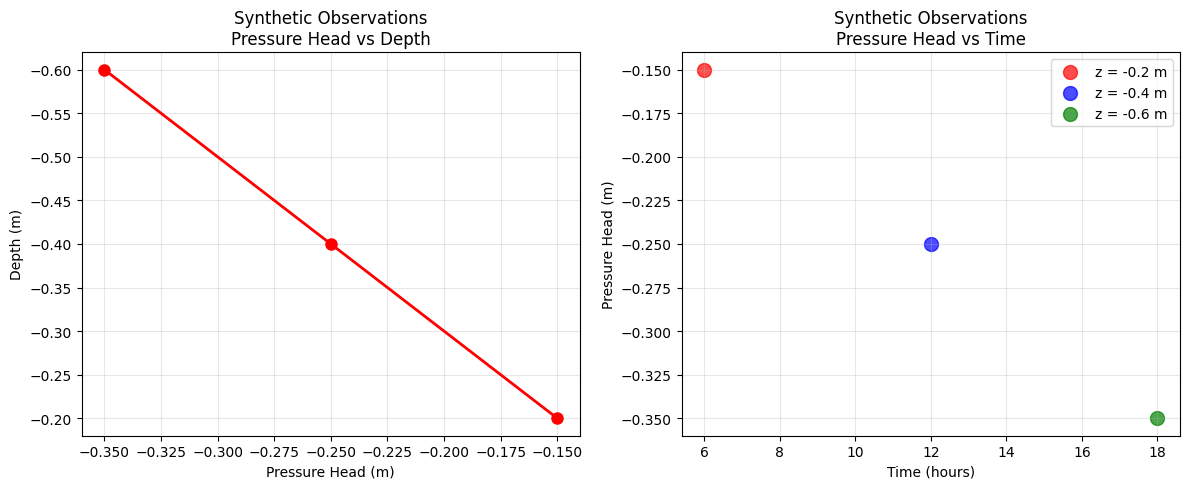

Synthetic observation data:
Depths: [-0.2 -0.4 -0.6] m
Times: [ 6. 12. 18.] hours
Pressure heads: [-0.15 -0.25 -0.35] m


In [502]:
# Generate synthetic observations for testing
# In practice, these would come from field measurements
z_obs = torch.tensor([[-0.20], [-0.40], [-0.60]], dtype=torch.float32).to(device)  # Converted from cm to m
t_obs = torch.tensor([[21600.0], [43200.0], [64800.0]], dtype=torch.float32).to(device)
h_obs = torch.tensor([[-0.15], [-0.25], [-0.35]], dtype=torch.float32).to(device)  # Converted from cm to m

observations = {"z": z_obs, "t": t_obs, "h": h_obs}

# Plot synthetic observation data
plt.figure(figsize=(12, 5))

# Generate synthetic observations for plotting
z_obs = torch.tensor([[-0.20], [-0.40], [-0.60]], dtype=torch.float32)  # Converted from cm to m
t_obs = torch.tensor([[21600.0], [43200.0], [64800.0]], dtype=torch.float32)
h_obs = torch.tensor([[-0.15], [-0.25], [-0.35]], dtype=torch.float32)  # Converted from cm to m

# Convert to numpy for plotting
z_plot = z_obs.numpy().flatten()
t_plot = t_obs.numpy().flatten() / 3600  # Convert to hours
h_plot = h_obs.numpy().flatten()

# Create subplot for depth vs pressure head
plt.subplot(1, 2, 1)
plt.plot(h_plot, z_plot, "ro-", markersize=8, linewidth=2)
plt.xlabel("Pressure Head (m)")
plt.ylabel("Depth (m)")
plt.title("Synthetic Observations\nPressure Head vs Depth")
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Invert y-axis so surface is at top

# Create subplot for time vs pressure head
plt.subplot(1, 2, 2)
colors = ["red", "blue", "green"]
depths = [-0.20, -0.40, -0.60]  # Converted to meters
for i in range(len(z_plot)):
    plt.scatter(
        t_plot[i], h_plot[i], c=colors[i], s=100, label=f"z = {depths[i]} m", alpha=0.7
    )

plt.xlabel("Time (hours)")
plt.ylabel("Pressure Head (m)")
plt.title("Synthetic Observations\nPressure Head vs Time")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Synthetic observation data:")
print(f"Depths: {z_plot} m")
print(f"Times: {t_plot} hours")
print(f"Pressure heads: {h_plot} m")

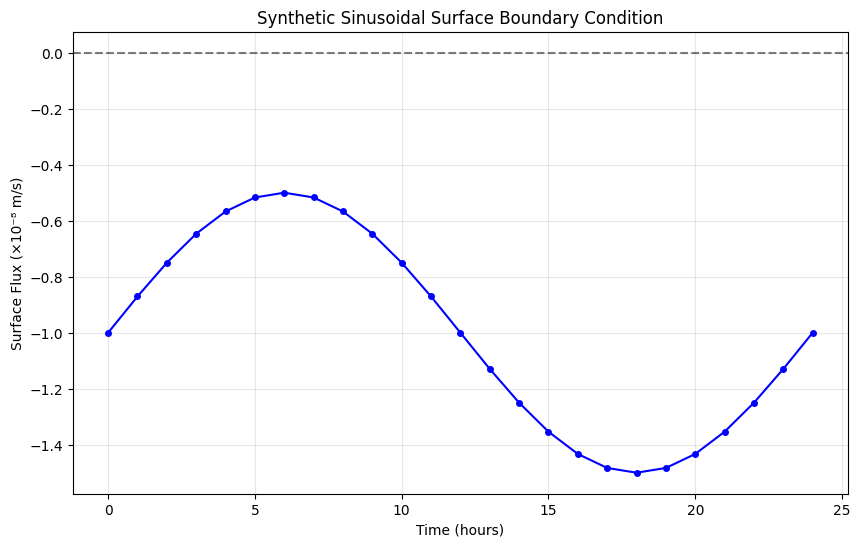

Synthetic q0_data generated:
Time range: 0.0 to 24.0 hours
Number of points: 25
Base flux: -1.00 ×10⁻⁸ m/s
Amplitude: ±0.50 ×10⁻⁸ m/s
Flux range: -1.50 to -0.50 ×10⁻⁸ m/s


In [503]:
# Generate synthetic sinusoidal surface boundary condition data
import numpy as np

# Time parameters
t_start = 0.0
t_end = 86400.0  # 24 hours in seconds
n_points = 49  # Higher resolution for smoother BC

# Create time array
t_q0 = np.linspace(t_start, t_end, n_points)

# Sinusoidal flux with daily cycle
# Base infiltration + sinusoidal variation (simulating daily rainfall pattern)
base_flux = -2e-8    # Stronger base infiltration (m/s)
amplitude = 1.5e-8   # Larger amplitude for more dynamic response
period = 86400.0  # 24-hour period (seconds)

q0_synthetic = base_flux + amplitude * np.sin(2 * np.pi * t_q0 / period)

# Create q0_data dictionary
q0_data = {
    "t": t_q0.tolist(),  # Convert to list
    "q": q0_synthetic.tolist(),  # Convert to list
}

# Plot the synthetic surface boundary condition
plt.figure(figsize=(10, 6))
plt.plot(
    np.array(q0_data["t"]) / 3600, np.array(q0_data["q"]) * 1e8, "b-o", markersize=4
)
plt.xlabel("Time (hours)")
plt.ylabel("Surface Flux (×10⁻⁸ m/s)")
plt.title("Synthetic Sinusoidal Surface Boundary Condition")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.5)
plt.show()

print("Synthetic q0_data generated:")
print(f"Time range: {t_start/3600:.1f} to {t_end/3600:.1f} hours")
print(f"Number of points: {n_points}")
print(f"Base flux: {base_flux*1e8:.2f} ×10⁻⁸ m/s")
print(f"Amplitude: ±{amplitude*1e8:.2f} ×10⁻⁸ m/s")
print(
    f"Flux range: {min(q0_data['q'])*1e8:.2f} to {max(q0_data['q'])*1e8:.2f} ×10⁻⁸ m/s"
)

In [ ]:
# Example usage
# Fixed parameters (from soil maps/PTF)
fixed_params = {
    "theta_s": 0.43,  # From bulk density
    "theta_r": 0.078,  # From PTF
    "l": 0.5,  # Mualem parameter
}

# Initial guesses for unknown parameters (ensure all positive)
initial_params = {"alpha": 3.6, "n": 1.56, "Ks": 1e-6}  # 1/m (was 0.036 × 100), dimensionless, m/s (was 1e-4 ÷ 100)

# Network configuration
network_config = {"hidden_dim": 50, "num_layers": 4}

# Training configuration
train_config = {
    "learning_rate": 1e-3,  # Reduced learning rate for stability
    "epochs": 16000,
    "n_collocation_z": 50,
    "n_collocation_t": 50,
    "n_bc_points": 100,
    "n_ic_points": 50,
    "h_init": lambda z: -0.10 - 0.5 * z,  # Initial pressure head (m) - was -10.0 cm
    "T_p": 0.0,  # No transpiration for now
    "w_pde": 1.0,
    "w_bc_surf": 1e2,  # Weight for surface boundary condition
    "w_bc_bottom": 5.0,  # Weight for bottom boundary condition (often less critical)
    "w_ic": 0.0,
    "w_obs": 100.0,  # Weight for observations
    "w_reg": 0.01,  # Weight for Tikhonov regularization
    "print_every": 1000,
    "gradient_clip": 1.0,  # Add gradient clipping
}


# Train the model
model, losses, loss_components = train_inverse_pinn_adaptive_autoweight(
    fixed_params=fixed_params,
    initial_params=initial_params,
    L=1.0,  # 1.0 m depth (was 100 cm)
    z_r=0.5,  # 0.5 m rooting depth (was 50 cm)
    c=0.05,  # Root decay parameter
    network_config=network_config,
    config=train_config,
    q0_data=q0_data,
    observations=observations,
)

# Print final estimated parameters
print("\nFinal estimated parameters:")
print(f"  α = {model.get_alpha().item():.6f} (1/cm)")
print(f"  n = {model.get_n().item():.4f}")
print(f"  Ks = {model.get_Ks().item():.6e} (cm/s)")

Training for 16000 epochs | lr=0.004
Cache size: 10000 | Batch size: 1000 | Resample freq: 50
High residual ratio: 0.7 | Temperature: 1.0
Time domain from q0: t∈[0, 86400.000], z∈[-1.000, 0]

Autoweight enabled: updating every 100 epochs, lr=0.5
Initial weights: {'pde': 1.0, 'bc_surf': 100.0, 'bc_bottom': 5.0, 'ic': 0.0, 'reg': 0.01, 'obs': 100.0}

[   0/16000]
  Losses (weighted): total=4.416e+00
    PDE=1.217e-15, Surf BC=8.343e-12
    Bottom BC=3.501e-16, IC=0.000e+00
    Reg=1.539e-01, Obs=4.262e+00
  Unweighted losses:
    PDE=1.217e-15, Surf BC=8.343e-14
    Bottom BC=7.002e-17, IC=1.001e-01
    Reg=1.539e+01, Obs=4.262e-02
  Weighted Gradients (L2 norm):
    PDE=5.717e-13, Surf BC=4.303e-10
    Bottom BC=4.712e-14, IC=0.000e+00
    Reg=2.598e-01, Obs=8.438e+01
    Total=8.438e+01
  Current weights:
    pde: 1.000e+00
    bc_surf: 1.000e+02
    bc_bottom: 5.000e+00
    ic: 0.000e+00
    reg: 1.000e-02
    obs: 1.000e+02
  Estimated parameters: α=3.5856, n=1.5578, Ks=0.000001
  Ca

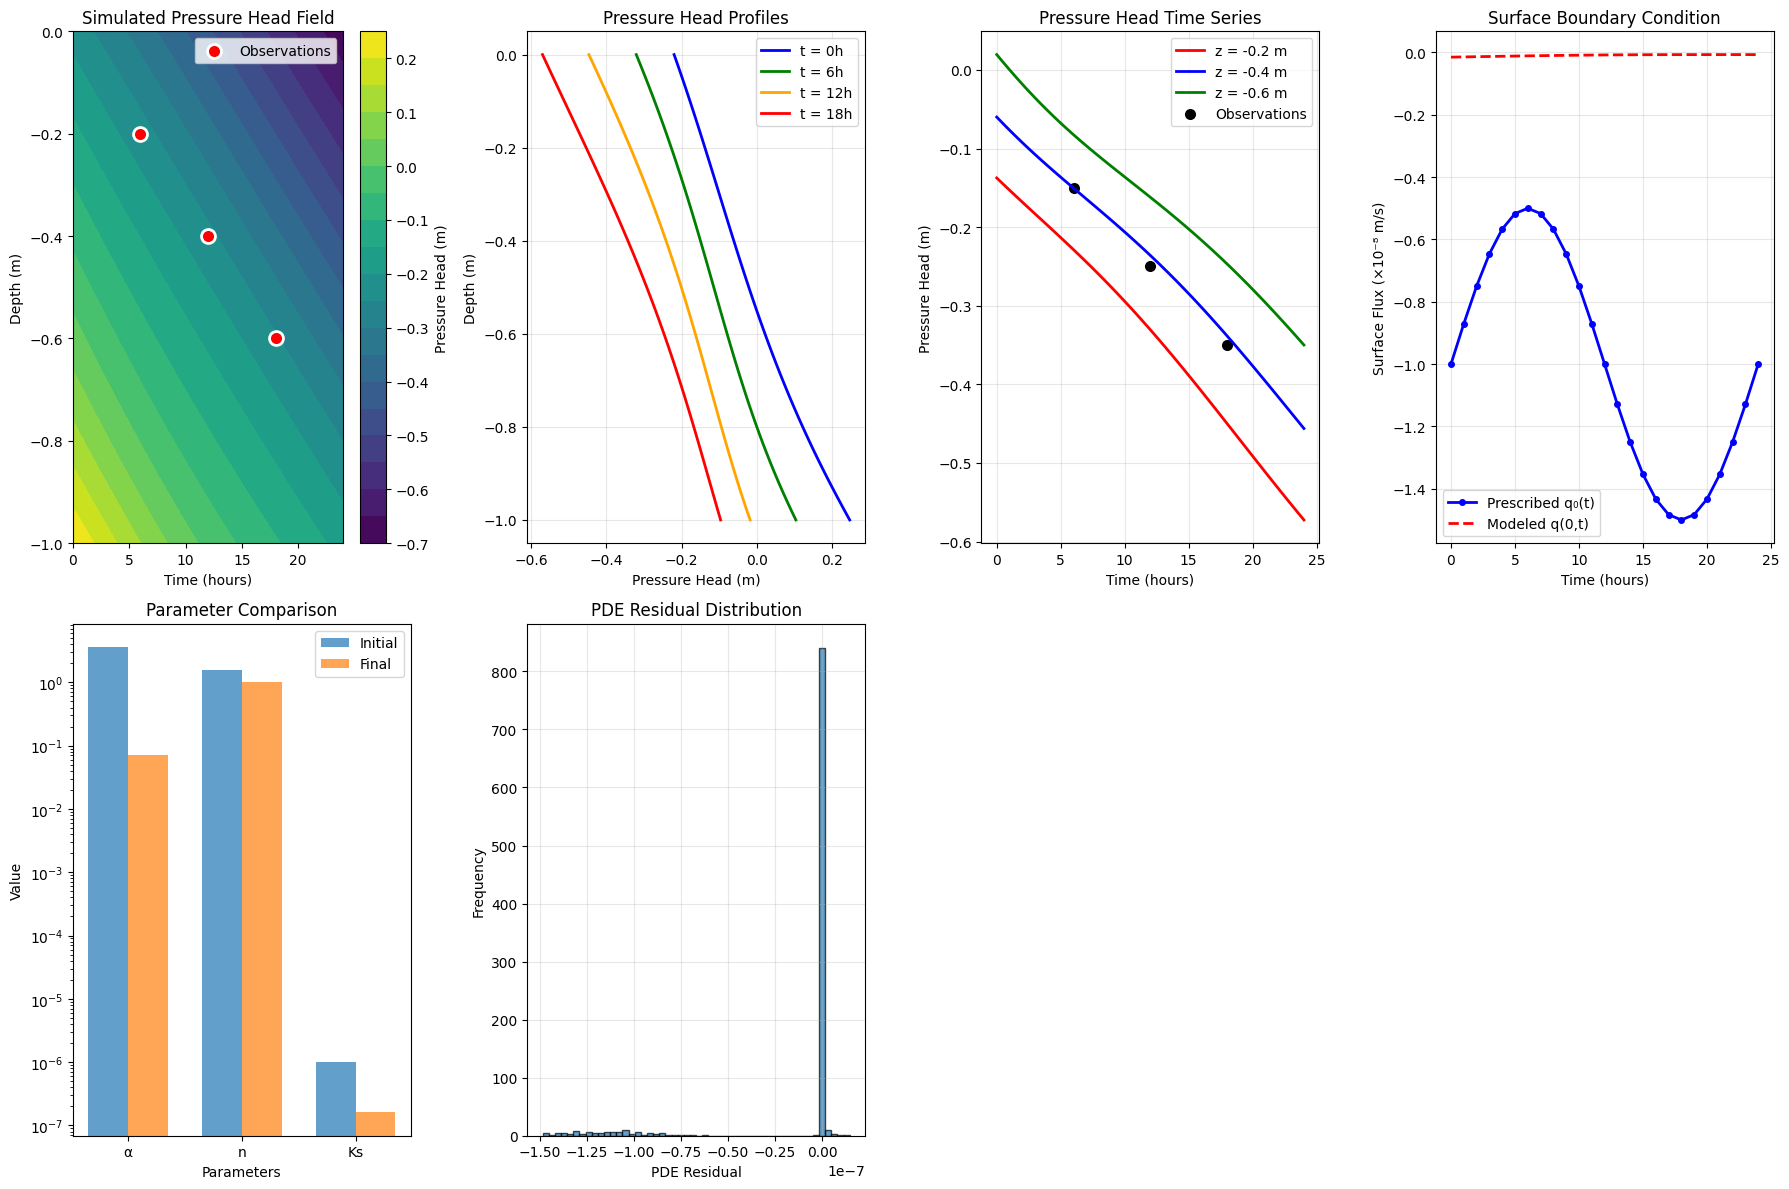

Model Visualization Complete!
Final Loss: 0.000036
Final Parameters:
  α = 0.070367 (1/cm)
  n = 1.0014
  Ks = 1.603794e-07 (cm/s)


In [505]:
# Comprehensive Model Visualization
import matplotlib.pyplot as plt
import numpy as np

# Set up the plotting parameters
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 10

# Create a comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Pressure head field visualization
# Create a fine grid for visualization
z_vis = torch.linspace(-model.L, 0, 100).reshape(-1, 1).to(device)
t_vis = torch.linspace(0, 86400, 50).reshape(-1, 1).to(device)

# Create meshgrid for visualization
Z_vis, T_vis = torch.meshgrid(z_vis.squeeze(), t_vis.squeeze(), indexing='ij')
z_flat = Z_vis.reshape(-1, 1)
t_flat = T_vis.reshape(-1, 1)

# Evaluate model on fine grid
model.eval()
with torch.no_grad():
    h_pred = model(z_flat, t_flat)
    h_field = h_pred.reshape(Z_vis.shape).cpu().numpy()

# Convert to numpy for plotting
Z_np = Z_vis.cpu().numpy()
T_np = T_vis.cpu().numpy() / 3600  # Convert to hours

# 2D pressure head field
ax1 = plt.subplot(2, 4, 1)
contour = plt.contourf(T_np, Z_np, h_field, levels=20, cmap='viridis')
plt.colorbar(contour, label='Pressure Head (m)')
plt.xlabel('Time (hours)')
plt.ylabel('Depth (m)')
plt.title('Simulated Pressure Head Field')

# Add observation points
if observations is not None:
    z_obs_np = observations['z'].cpu().numpy().flatten()
    t_obs_np = observations['t'].cpu().numpy().flatten() / 3600
    plt.scatter(t_obs_np, z_obs_np, c='red', s=100, marker='o', 
                edgecolors='white', linewidth=2, label='Observations')
    plt.legend()

# 2. Pressure head profiles at different times
ax2 = plt.subplot(2, 4, 2)
time_snapshots = [0, 6, 12, 18, 24]  # hours
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, t_snap in enumerate(time_snapshots):
    t_idx = int(t_snap * len(t_vis) / 24)
    if t_idx < h_field.shape[1]:
        plt.plot(h_field[:, t_idx], z_vis.cpu().numpy().flatten(), 
                color=colors[i], linewidth=2, label=f't = {t_snap}h')

plt.xlabel('Pressure Head (m)')
plt.ylabel('Depth (m)')
plt.title('Pressure Head Profiles')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Time series at observation depths
ax3 = plt.subplot(2, 4, 3)
if observations is not None:
    obs_depths = [-0.20, -0.40, -0.60]  # m (converted from cm)
    colors_ts = ['red', 'blue', 'green']
    
    for i, depth in enumerate(obs_depths):
        # Find closest depth index
        depth_idx = torch.argmin(torch.abs(z_vis - depth))
        h_timeseries = h_field[depth_idx, :]
        plt.plot(T_np[0, :], h_timeseries, color=colors_ts[i], 
                linewidth=2, label=f'z = {depth} m')
    
    # Add observation points
    z_obs_np = observations['z'].cpu().numpy().flatten()
    t_obs_np = observations['t'].cpu().numpy().flatten() / 3600
    h_obs_np = observations['h'].cpu().numpy().flatten()
    plt.scatter(t_obs_np, h_obs_np, c='black', s=100, marker='o', 
                edgecolors='white', linewidth=2, label='Observations')

plt.xlabel('Time (hours)')
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Surface boundary condition (prescribed vs modeled)
ax4 = plt.subplot(2, 4, 4)
# Plot prescribed surface flux
plt.plot(np.array(q0_data["t"]) / 3600, np.array(q0_data["q"]) * 1e8, 
         'b-o', markersize=4, linewidth=2, label='Prescribed q₀(t)')

# Compute modeled surface flux using the trained model
t_surface = torch.tensor(q0_data["t"], dtype=torch.float32).reshape(-1, 1).to(device)
t_surface.requires_grad_(True)
z_surface = torch.zeros_like(t_surface, requires_grad=True)

# Get surface flux from model (need gradients for compute_derivatives)
_, _, q_surface, _, _ = model.compute_derivatives(z_surface, t_surface)
q_modeled = q_surface.detach().cpu().numpy().flatten()

plt.plot(np.array(q0_data["t"]) / 3600, q_modeled * 1e8, 
         'r--', linewidth=2, label='Modeled q(0,t)')

plt.xlabel('Time (hours)')
plt.ylabel('Surface Flux (×10⁻⁸ m/s)')
plt.title('Surface Boundary Condition')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Parameter comparison (initial vs final)
ax5 = plt.subplot(2, 4, 5)
# For now, show final estimated vs initial parameters
params = ['α', 'n', 'Ks']
initial_vals = [initial_params['alpha'], initial_params['n'], initial_params['Ks']]
final_vals = [model.get_alpha().item(), model.get_n().item(), model.get_Ks().item()]

x = np.arange(len(params))
width = 0.35

plt.bar(x - width/2, initial_vals, width, label='Initial', alpha=0.7)
plt.bar(x + width/2, final_vals, width, label='Final', alpha=0.7)

plt.xlabel('Parameters')
plt.ylabel('Value')
plt.title('Parameter Comparison')
plt.xticks(x, params)
plt.legend()
plt.yscale('log')

# 6. Residual analysis
ax6 = plt.subplot(2, 4, 6)
# Compute PDE residual on a subset of points for visualization
n_sample = 1000
z_sample = torch.linspace(-model.L, 0, int(np.sqrt(n_sample))).reshape(-1, 1).to(device)
t_sample = torch.linspace(0, 86400, int(np.sqrt(n_sample))).reshape(-1, 1).to(device)
Z_sample, T_sample = torch.meshgrid(z_sample.squeeze(), t_sample.squeeze(), indexing='ij')
z_res = Z_sample.reshape(-1, 1).requires_grad_(True)  # Enable gradients
t_res = T_sample.reshape(-1, 1).requires_grad_(True)  # Enable gradients

# Don't use no_grad when computing residuals since we need gradients
residual = model.pde_residual(z_res, t_res, train_config.get("T_p", 0.0))
residual_np = residual.detach().cpu().numpy().flatten()

plt.hist(residual_np, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('PDE Residual')
plt.ylabel('Frequency')
plt.title('PDE Residual Distribution')
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

print("Model Visualization Complete!")
print(f"Final Loss: {losses[-1]:.6f}")
print(f"Final Parameters:")
print(f"  α = {model.get_alpha().item():.6f} (1/cm)")
print(f"  n = {model.get_n().item():.4f}")
print(f"  Ks = {model.get_Ks().item():.6e} (cm/s)")


/var/folders/_l/jjtpvbqx2ysck3r6lp7nnv600000gn/T/ipykernel_64009/2032954320.py:78: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


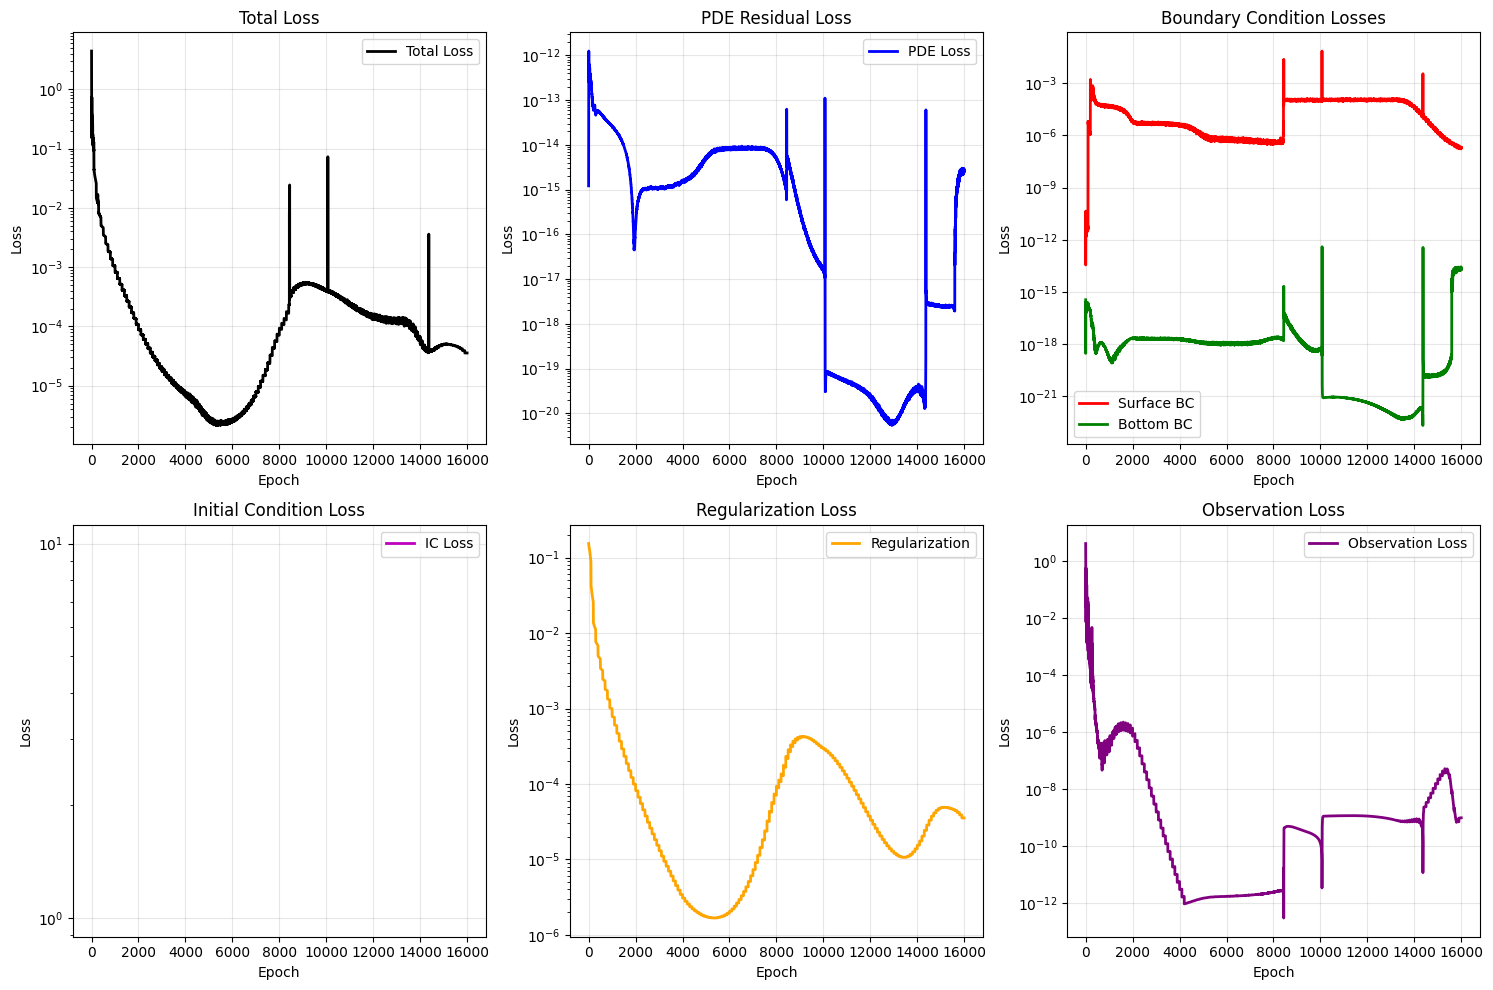

Final Loss Component Values:
Total Loss: 0.000036
PDE Loss: 0.000000
Surface BC Loss: 0.000000
Bottom BC Loss: 0.000000
Initial Condition Loss: 0.000000
Regularization Loss: 0.000035
Observation Loss: 0.000000


In [506]:
# Plot loss components
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))

epochs = np.arange(len(loss_components['total']))

# 1. Total loss
plt.subplot(2, 3, 1)
plt.semilogy(epochs, loss_components['total'], 'k-', linewidth=2, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. PDE residual loss
plt.subplot(2, 3, 2)
plt.semilogy(epochs, loss_components['pde'], 'b-', linewidth=2, label='PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PDE Residual Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Boundary condition losses
plt.subplot(2, 3, 3)
plt.semilogy(epochs, loss_components['bc_surf'], 'r-', linewidth=2, label='Surface BC')
plt.semilogy(epochs, loss_components['bc_bottom'], 'g-', linewidth=2, label='Bottom BC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Boundary Condition Losses')
plt.grid(True, alpha=0.3)
plt.legend()

# 4. Initial condition loss
plt.subplot(2, 3, 4)
plt.semilogy(epochs, loss_components['ic'], 'm-', linewidth=2, label='IC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Initial Condition Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 5. Regularization loss
plt.subplot(2, 3, 5)
plt.semilogy(epochs, loss_components['reg'], 'orange', linewidth=2, label='Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Regularization Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 6. Observation loss (if available)
plt.subplot(2, 3, 6)
if any(val > 0 for val in loss_components['obs']):
    plt.semilogy(epochs, loss_components['obs'], 'purple', linewidth=2, label='Observation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Observation Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
else:
    # Plot all components together for comparison
    plt.semilogy(epochs, loss_components['total'], 'k-', linewidth=2, label='Total')
    plt.semilogy(epochs, loss_components['pde'], 'b-', linewidth=1, label='PDE')
    plt.semilogy(epochs, loss_components['bc_surf'], 'r-', linewidth=1, label='Surface BC')
    plt.semilogy(epochs, loss_components['bc_bottom'], 'g-', linewidth=1, label='Bottom BC')
    plt.semilogy(epochs, loss_components['ic'], 'm-', linewidth=1, label='IC')
    plt.semilogy(epochs, loss_components['reg'], 'orange', linewidth=1, label='Regularization')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('All Loss Components')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# Print final loss component values
print("Final Loss Component Values:")
print(f"Total Loss: {loss_components['total'][-1]:.6f}")
print(f"PDE Loss: {loss_components['pde'][-1]:.6f}")
print(f"Surface BC Loss: {loss_components['bc_surf'][-1]:.6f}")
print(f"Bottom BC Loss: {loss_components['bc_bottom'][-1]:.6f}")
print(f"Initial Condition Loss: {loss_components['ic'][-1]:.6f}")
print(f"Regularization Loss: {loss_components['reg'][-1]:.6f}")
if any(val > 0 for val in loss_components['obs']):
    print(f"Observation Loss: {loss_components['obs'][-1]:.6f}")
else:
    print("Observation Loss: Not used")
